In [1]:
import time
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from tqdm import tqdm
# версия chroma 114

In [2]:
import os
wd = os.getcwd()
wd = wd[:-wd[::-1].find("\\")]
wd_data = "data\\"

In [3]:
import sys
sys.path.append(wd + 'scripts')
sys.path.append(wd + 'dashboard')

In [7]:
from Paesers import ozon, yand, wb, to_num

In [9]:
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd

In [11]:
#Сбор данных

In [13]:
def create_web_driver_stealth() -> webdriver.Chrome:
    options = webdriver.ChromeOptions()
    options.add_argument("start-maximized")
    #options.add_argument("--headless")
    options.add_experimental_option("excludeSwitches", ["enable-automation"])
    options.add_experimental_option('useAutomationExtension', False)

    s = Service(ChromeDriverManager().install())
    stealth_driver = webdriver.Chrome(service=s, options=options)

    stealth(stealth_driver,
            languages=["en-US", "en"],
            vendor="Google Inc.",
            platform="Win32",
            webgl_vendor="Intel Inc.",
            renderer="Intel Iris OpenGL Engine",
            fix_hairline=True,
            )

    return stealth_driver

In [15]:
sites = ["https://www.ozon.ru",  "https://market.yandex.ru", "https://www.wildberries.ru"]
list_request = ["Кружка", "Термопаста", "Mars", "Носки", "Куртка"]

df = pd.DataFrame({'title': [], 'price': [],'rating': [],'reviews':[],'market': [],'link': [],'req': []})

start_time = time.perf_counter()  # про time.perf_counter https://superfastpython.com/time-time-vs-time-perf_counter/
driver = create_web_driver_stealth()

for url in sites: 
    driver.get(url)
    time.sleep(1)
    if url == "https://market.yandex.ru/":
        time.sleep(4)
        actions = ActionChains(driver)
        actions.move_by_offset(10, 10).click().perform()
    print(url)
    for req in tqdm(list_request):
        if url == "https://market.yandex.ru":
            df = yand(req, driver, df)
        elif url == "https://www.ozon.ru":
            df = ozon(req, driver, df)
        elif url == "https://www.wildberries.ru":
            df = wb(req, driver, df)
    
duration = time.perf_counter() - start_time
    
print(f"Downloaded {len(sites)} sites in {duration} seconds")

https://www.ozon.ru


100%|██████████| 5/5 [00:30<00:00,  6.02s/it]


https://market.yandex.ru


100%|██████████| 5/5 [00:42<00:00,  8.58s/it]


https://www.wildberries.ru


100%|██████████| 5/5 [00:31<00:00,  6.39s/it]

Downloaded 3 sites in 114.2587222000002 seconds


In [17]:
# Сохраним данные

In [19]:
#df.to_csv(wd + wd_data +'dataset_marketplaces_2.csv')

In [21]:
#Загрузка данных

In [11]:
df = pd.read_csv(wd + wd_data +'dataset_marketplaces_2.csv').drop("Unnamed: 0", axis = 1)

In [13]:
# Посмотрим датасет
df

,title,price,rating,reviews,market,link,req
0,"Кружка для чая и кофе Montserrat с крышкой, 38...",603 ₽,4.6,393,ozon,https://www.ozon.ru/product/kruzhka-dlya-chaya...,Кружка
1,"Кружка ""Золотой дракон"", объем 350 мл, с крышк...",754 ₽,4.6,421,ozon,https://www.ozon.ru/product/kruzhka-zolotoy-dr...,Кружка
2,"Кружка Oxilife, чайная пара, 200 мл перламутровая",558 ₽,4.9,23,ozon,https://www.ozon.ru/product/kruzhka-oxilife-ch...,Кружка
3,"Кружка для чая и кофе на 400мл ""Morning"" на 50...",169 ₽,4.8,1869,ozon,https://www.ozon.ru/product/kruzhka-dlya-chaya...,Кружка
4,"Кружка с принтом ""Ща раздуплюсь""",410 ₽,5.0,4,ozon,https://www.ozon.ru/product/kruzhka-s-printom-...,Кружка
...,...,...,...,...,...,...,...
754,Куртка демисезонная с капюшоном QASO,2328,4.4,919,wb,https://www.wildberries.ru/catalog/179244724/d...,Куртка
755,Кожаная куртка с капюшоном зимняя пуховик ZARINA,1986,4.7,1538,wb,https://www.wildberries.ru/catalog/180093549/d...,Куртка
756,Куртка тедди двусторонняя демисезонная чебураш...,3266,4.2,739,wb,https://www.wildberries.ru/catalog/172131459/d...,Куртка
757,Куртка стеганая оверсайз удлиненная с капюшоно...,3056,4.6,2201,wb,https://www.wildberries.ru/catalog/180093522/d...,Куртка


In [15]:
# Проверим корректность данных
df[df['rating'].apply(lambda x: 'шт' in x)]

,title,price,rating,reviews,market,link,req
74,термопаста1гр GD900-1 для CPU,116 ₽,Осталось 30 шт,30,ozon,https://www.ozon.ru/product/termopasta1gr-gd90...,Термопаста


In [17]:
# один товар(id 11) неправильно запарсился

In [19]:
# Если есть шт, то данные не корректы
df = df[df['rating'].apply(lambda x: not('шт' in x))]

In [21]:
# Достанем ссылку и проверим соответствие данных товара
print(df.loc[53])
df.loc[53]["link"]

title                        Термопаста Arctic MX-6 2 грамма
price                                                  461 ₽
rating                                                   4.6
reviews                                                 3890
market                                                  ozon
link       https://www.ozon.ru/product/termopasta-arctic-...
req                                               Термопаста
Name: 53, dtype: object


'https://www.ozon.ru/product/termopasta-arctic-mx-6-2-gramma-836360511/?at=J8tg9NLRwT5EAP9jU6qWkNoiX9QD56H5jnMRjfXWvrE4'

In [23]:
# Поменяем тип данных на корректный
df.price = df.price.apply(to_num)
df.rating = df.rating.astype(float)

C:\Users\arsry\AppData\Local\Temp\ipykernel_7920\3240558984.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.price = df.price.apply(to_num)
C:\Users\arsry\AppData\Local\Temp\ipykernel_7920\3240558984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rating = df.rating.astype(float)


In [25]:
print("\nПропуски в данных:")
print(df.isnull().sum())


Пропуски в данных:
title      0
price      0
rating     0
reviews    0
market     0
link       0
req        0
dtype: int64


In [27]:
#пропусков нет

In [29]:
print("\nОписательные статистики:")
print(df.describe(include='all'))


Описательные статистики:
         title         price      rating        reviews market  \
count      758    758.000000  758.000000     758.000000    758   
unique     624           NaN         NaN            NaN      3   
top     Куртка           NaN         NaN            NaN   yand   
freq        17           NaN         NaN            NaN    323   
mean       NaN   1184.948549    4.808971    9027.738786    NaN   
std        NaN   1871.926144    0.197136   46043.920148    NaN   
min        NaN     78.000000    2.800000       1.000000    NaN   
25%        NaN    360.250000    4.800000      56.250000    NaN   
50%        NaN    593.000000    4.900000     435.500000    NaN   
75%        NaN   1178.000000    4.900000    3111.000000    NaN   
max        NaN  33972.000000    5.000000  874986.000000    NaN   

                                                     link     req  
count                                                 758     758  
unique                                       

In [31]:
df[df.reviews == 874986]["link"].values

array(['https://www.wildberries.ru/catalog/19252625/detail.aspx'],
      dtype=object)

In [33]:
#рейтинг везде был в пятибальной шкале, максимум - 5, а минимум у нас 3. Всё курто
#Количесиво отзывов смущает, но 800к отзывов у кислородного коктеля есть(позже убрём товары, которые нам не подходят)
#Цена в рамках адекватных значений

In [35]:
# Удалим данные с пропусками(на всякий случай) и дубликаты
df = df.dropna()
df = df.drop_duplicates()

#Очистим от товаров не содержащих интересующее нас слово
df = df[df.apply(lambda x: x['req'].lower() in x['title'].lower(), axis=1)]

#Очистим данные от выбросов

def clearing(df, reqvest, col_name = "price"):
    filtred_df = df[df.req == reqvest]
    q1 = filtred_df[col_name].quantile(0.25)
    q3 = filtred_df[col_name].quantile(0.75)
    iqr = q3 - q1
    df = df[((df[col_name] < q3 + 1.5 * iqr) & (df[col_name] > q1 - 1.5 * iqr)) | (df.req != reqvest)]
    return df


list_request = ["Кружка", "Термопаста mx-4", "Mars", "Носки", "Куртка"]
for i in list_request:
    df = clearing(df, i)
df

,title,price,rating,reviews,market,link,req
0,"Кружка для чая и кофе Montserrat с крышкой, 38...",603,4.6,393,ozon,https://www.ozon.ru/product/kruzhka-dlya-chaya...,Кружка
1,"Кружка ""Золотой дракон"", объем 350 мл, с крышк...",754,4.6,421,ozon,https://www.ozon.ru/product/kruzhka-zolotoy-dr...,Кружка
2,"Кружка Oxilife, чайная пара, 200 мл перламутровая",558,4.9,23,ozon,https://www.ozon.ru/product/kruzhka-oxilife-ch...,Кружка
3,"Кружка для чая и кофе на 400мл ""Morning"" на 50...",169,4.8,1869,ozon,https://www.ozon.ru/product/kruzhka-dlya-chaya...,Кружка
4,"Кружка с принтом ""Ща раздуплюсь""",410,5.0,4,ozon,https://www.ozon.ru/product/kruzhka-s-printom-...,Кружка
...,...,...,...,...,...,...,...
752,Куртка демисезонная с капюшоном KOBYLA,2293,4.7,1525,wb,https://www.wildberries.ru/catalog/169834668/d...,Куртка
754,Куртка демисезонная с капюшоном QASO,2328,4.4,919,wb,https://www.wildberries.ru/catalog/179244724/d...,Куртка
755,Кожаная куртка с капюшоном зимняя пуховик ZARINA,1986,4.7,1538,wb,https://www.wildberries.ru/catalog/180093549/d...,Куртка
756,Куртка тедди двусторонняя демисезонная чебураш...,3266,4.2,739,wb,https://www.wildberries.ru/catalog/172131459/d...,Куртка


In [37]:
#более наглядно и с очищенными данными
# Анализ числовых переменных
numeric_cols = ['price', 'rating', 'reviews']
for col in numeric_cols:
    print(f"\nАнализ столбца {col}:")
    print(f"Медиана: {df[col].median()}")
    print(f"Среднее: {df[col].mean()}")
    print(f"Стандартное отклонение: {df[col].std()}")
    print(f"Минимум: {df[col].min()}")
    print(f"Максимум: {df[col].max()}")
    print(f"Количество нулевых значений: {(df[col] == 0).sum()}")


Анализ столбца price:
Медиана: 575.0
Среднее: 972.721044045677
Стандартное отклонение: 1074.9911652612582
Минимум: 78
Максимум: 5644
Количество нулевых значений: 0

Анализ столбца rating:
Медиана: 4.9
Среднее: 4.816313213703099
Стандартное отклонение: 0.18139288536505646
Минимум: 3.0
Максимум: 5.0
Количество нулевых значений: 0

Анализ столбца reviews:
Медиана: 421.0
Среднее: 5091.9461663947795
Стандартное отклонение: 18490.94314356628
Минимум: 1
Максимум: 218556
Количество нулевых значений: 0


In [39]:
#Пока все значения в пределах нормы

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'Количество')

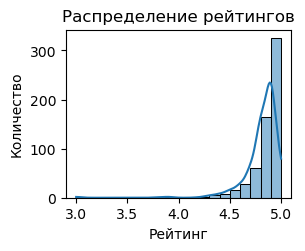

In [42]:
plt.subplot(2, 2, 2)
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Распределение рейтингов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')

In [43]:
#Данные смещены влево, так как на первых располагаются поулярные товары, а раз они популярны, то нравятся людям

In [44]:
df

,title,price,rating,reviews,market,link,req
0,"Кружка для чая и кофе Montserrat с крышкой, 38...",603,4.6,393,ozon,https://www.ozon.ru/product/kruzhka-dlya-chaya...,Кружка
1,"Кружка ""Золотой дракон"", объем 350 мл, с крышк...",754,4.6,421,ozon,https://www.ozon.ru/product/kruzhka-zolotoy-dr...,Кружка
2,"Кружка Oxilife, чайная пара, 200 мл перламутровая",558,4.9,23,ozon,https://www.ozon.ru/product/kruzhka-oxilife-ch...,Кружка
3,"Кружка для чая и кофе на 400мл ""Morning"" на 50...",169,4.8,1869,ozon,https://www.ozon.ru/product/kruzhka-dlya-chaya...,Кружка
4,"Кружка с принтом ""Ща раздуплюсь""",410,5.0,4,ozon,https://www.ozon.ru/product/kruzhka-s-printom-...,Кружка
...,...,...,...,...,...,...,...
752,Куртка демисезонная с капюшоном KOBYLA,2293,4.7,1525,wb,https://www.wildberries.ru/catalog/169834668/d...,Куртка
754,Куртка демисезонная с капюшоном QASO,2328,4.4,919,wb,https://www.wildberries.ru/catalog/179244724/d...,Куртка
755,Кожаная куртка с капюшоном зимняя пуховик ZARINA,1986,4.7,1538,wb,https://www.wildberries.ru/catalog/180093549/d...,Куртка
756,Куртка тедди двусторонняя демисезонная чебураш...,3266,4.2,739,wb,https://www.wildberries.ru/catalog/172131459/d...,Куртка


In [45]:
#сохраним очищенные данные
#df.to_csv(wd + wd_data +'dataset_marketplaces_clean.csv')

In [17]:
df = pd.read_csv(wd + wd_data +'dataset_marketplaces_clean.csv').drop("Unnamed: 0", axis = 1)

In [19]:
# Наш скрипт для дэшборда
from app_dashbord import app_dash

In [20]:
if __name__ == '__main__':
    app = app_dash(df)
    app.app.run(debug=True, port = 8850)

In [23]:
# лучше открыть в браузере
driver = create_web_driver_stealth()
driver.get("http://localhost:8850/")